# **Data Analysis of the Thomas Fire in Ventura and Santa Barbara Counties, 2017**
### Author: Bailey Jørgensen 
*Repository Link: https://github.com/jorb1/eds220-hwk4*


![Image of Fire](https://www.independent.com/wp-content/uploads/2017/12/13/MorganMaassen_2017_ThomasFire_-_3.jpg)



## Background:

The Thomas Fire, which burned over 280,000 acres in Ventura and Santa Barbara counties in December 2017, was one of California’s largest wildfires at the time. It caused widespread ecological damage, displaced communities, and left lasting environmental impacts.

In this analysis, I will find the perimeter of the fire, analyze spatial data of the lasting fire scars through false color images, and visualize the effects that this fire had on air quality in the Santa Barbara area.  
 

**About the data**

In this task I will use historical open-access data about fire perimeters in California. There are several datasets with this information online. The dataset that I found is from data.gov at this link: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436. It was a particularly useful site, as there were multiple filetypes to choose from. 

The next dataset I will use is a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. These data were retrieved from the Microsof Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution. (This data should be used for visualization and educational purposes only.)

Finally, I will use [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov) to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County.



### First up in my Analysis: 
**Fire perimeter data retrieval and selection**

I will find and isolate the perimeter of the Thomas Fire, using open source data. I will then be able to use the Thomas Fire perimeter data in further analysis of the effects of the fire on Santa Barbara ecology. I will save this perimeter data as a file in my repository, for independent use in other notebooks.

a. To begin, I will do some exploratory data analysis to get a sense of the dataset I am using. I will ensure that I know the CRS of the data, for use in further spatial data joining and analysis. 


In [1]:
# Load libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import rioxarray as rioxr
import xarray as xr

# Read in data 

fp_perimeter = os.path.join('data', 'California_Fire_Perimeters_(all).shp')
perimeter = gpd.read_file(fp_perimeter)

In [2]:
perimeter.head(3)

YEAR_ STATE AGENCY UNIT_ID  FIRE_NAME   INC_NUM  ALARM_DATE   CONT_DATE  \
0   2023    CA    CDF     SKU  WHITWORTH  00004808  2023-06-17  2023-06-17   
1   2023    CA    LRA     BTU     KAISER  00010225  2023-06-02  2023-06-02   
2   2023    CA    CDF     AEU    JACKSON  00017640  2023-07-01  2023-07-02   

   CAUSE  C_METHOD  OBJECTIVE  GIS_ACRES COMMENTS COMPLEX_NA  \
0      5         1          1    5.72913     None       None   
1      5         1          1   13.60240     None       None   
2      2         1          1   27.81450     None       None   

                                  IRWINID FIRE_NUM COMPLEX_ID  DECADES  \
0  {7985848C-0AC2-4BA4-8F0E-29F778652E61}     None       None     2020   
1  {43EBCC88-B3AC-48EB-8EF5-417FE0939CCF}     None       None     2020   
2  {B64E1355-BF1D-441A-95D0-BC1FBB93483B}     None       None     2020   

                                            geometry  
0  POLYGON ((-13682443.000 5091132.739, -13682445...  
1  POLYGON ((-13576727.142 4841226.161, -13576726...  
2  POLYGON ((-13459243.000 4621236.000, -13458968...

In [3]:
# Figure out the dimensions of the dataframe
print("Shape of the data:", perimeter.shape)

# Figure out if the columns are the expected datatypes
print("Data types:", perimeter.dtypes)

Shape of the data: (22261, 19)
Data types: YEAR_            int64
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE            int64
C_METHOD         int64
OBJECTIVE        int64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
IRWINID         object
FIRE_NUM        object
COMPLEX_ID      object
DECADES          int64
geometry      geometry
dtype: object


In [4]:
# Explore data CRS
perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# Find out if its projected or geographic
perimeter.crs.is_projected

True

From this data exploration, I learned that the dataset is much larger than I need, but does contain useful information in addition to the geometries, such as acres burned, cause, etc. I learned that the names of the fires are in all capitals, and that the year numbers are INT64, so I can treat them as numeric values. Finally, I leaned that the CRS is WGS 84, and that is is projected data, rather than geographic.


b. From this fire perimeter data, select the Thomas Fire boundary. The fire occurred in 2017.

In [6]:
# First, make the column names easier to work with
perimeter.columns = perimeter.columns.str.lower()

# Filter data to only include the Thomas Fire boudnary in 2017
thomas = perimeter[(perimeter['fire_name'] == "THOMAS") & (perimeter['year_'] == 2017)]

thomas

year_ state agency unit_id fire_name   inc_num  alarm_date   cont_date  \
2654   2017    CA    USF     VNC    THOMAS  00003583  2017-12-04  2018-01-12   

      cause  c_method  objective  gis_acres                    comments  \
2654      9         7          1   281791.0  CONT_DATE based on Inciweb   

     complex_na irwinid fire_num complex_id  decades  \
2654       None    None     None       None     2010   

                                               geometry  
2654  MULTIPOLYGON (((-13316089.016 4088553.040, -13...

c. Save only the 2017 Thomas Fire boundary as a geospatial file in the format of my choosing. The file should go into the data/ directory in my repository.

In [7]:
# Save the fire boundary as a file that can go into my repository
# Save the filtered GeoDataFrame as a GeoJSON file
path = 'data/thomas.geojson'
thomas.to_file(path, driver='GeoJSON')

d. I chose to use a GeoJSON file format for my perimeter boundary, because it is a common and useful "open format for encoding vector points and their attributes". It comes in one file, as compared to .shp files, which have many dependencies. It requires the data be in WGS84, and since I already verified that this data is in that CRS, it seems like the best possible option for this analysis.  

#  Visualizing fire scars through false color

False color imagery, created using satellite data from instruments like Landsat, is a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars. This approach helps researchers and land managers assess recovery efforts, identify high-risk areas, and plan restoration strategies.

I will create a false color image of the Thomas Fire using remote sensing data, highlighting the fire scar and exploring how coding and data visualization support environmental monitoring.

## Next up: 

### True Color Image

In [8]:
# Construct a file path to the Landsat data using os and import it
fp = os.path.join('data', 'landsat8-2018-01-26-sb-simplified.nc')
sb_rast = rioxr.open_rasterio(fp, decode_coords="all")
sb_rast

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [9]:
#Explore the data and write a brief summary of the information you obtained from the preliminary information. 
print('Shape: ', dict(sb_rast.sizes))
print(sb_rast.data_vars, '\n')

Shape:  {'band': 1, 'x': 870, 'y': 731}
Data variables:
    red      (band, y, x) float64 5MB ...
    green    (band, y, x) float64 5MB ...
    blue     (band, y, x) float64 5MB ...
    nir08    (band, y, x) float64 5MB ...
    swir22   (band, y, x) float64 5MB ... 



This data exploration shows me that there is only one band on this raster. This means that including it is redundant, and the band will need to be removed. I also learned that each color band is a float64 integer, which is good to know when doing analysis. 

In [10]:
#Drop the band dimension of the data. HINT: squeeze() and drop_vars().
# Original dimensions and coordinates
print(sb_rast.dims, sb_rast.coords, '\n')

# Remove length 1 dimension (band)
sb_rast = sb_rast.squeeze()
print(sb_rast.dims, sb_rast.coords, '\n')

# Drop the coordinates associated to band
sb_rast = sb_rast.drop_vars('band')
print(sb_rast.dims, sb_rast.coords, '\n')

FrozenMappingWarningOnValuesAccess({'band': 1, 'x': 870, 'y': 731}) Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0 

FrozenMappingWarningOnValuesAccess({'x': 870, 'y': 731}) Coordinates:
    band         int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0 

FrozenMappingWarningOnValuesAccess({'x': 870, 'y': 731}) Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0 



To get a good look at this raster data, without creating any new variables:

I will select the red, green, and blue variables (in that order) of the xarray.Dataset holding the Landsat data,
convert it to a numpy.array using the to_array() method, and then use .plot.imshow() to create an RGB image with the data. There will be a warning, that’s ok.
I will adjust the scale used for plotting the bands to get a true color image.

The first plot will have the parameter set to be robust=False. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


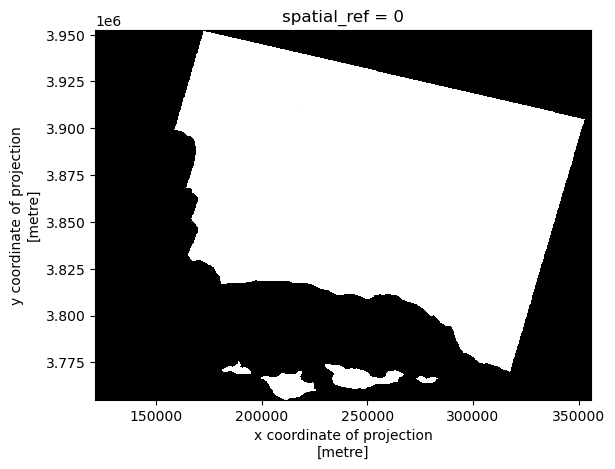

In [11]:
# Select red, green, and blue variables, stack them, and plot as an RGB image
sb_rast[['red', 'green', 'blue']].to_array().plot.imshow(robust=False)

As we can see, this doesn't turn out quite as we'd hoped. That's because, by setting that parameter to False, we are not accounting for cloud cover. Their RGB values are outliers and cause the other values to be squished when plotting.

To account for this, I will use the robust = True parameter at the end of my code, in order to deal with the clouds: 

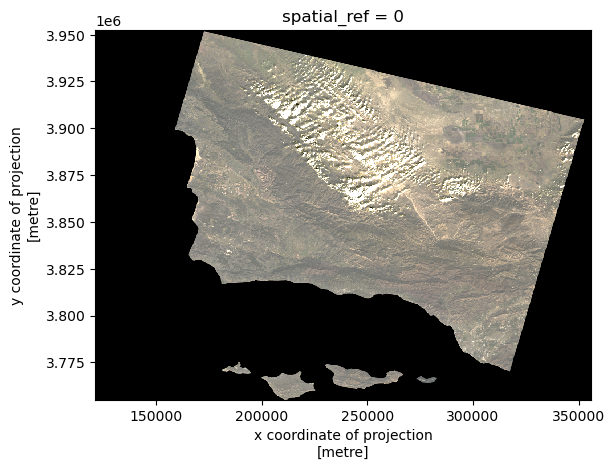

In [12]:
# Select red, green, and blue variables, stack them, and plot as an RGB image
sb_rast[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

This true color image gives us a visual that mostly resembles what we would expect to see with our human eyes looking down on Santa Barbara. The colors are what we would expect to see, and this can be useful for identifying landmarks. However, sometimes it is important to get a new perspective. For example, using this map, it is almost impossible to see the area in which the Thomas Fire burned. And that's when we bring in...

### 4. False color image

To continue my analysis, and without creating any new variables, create a false color image by plotting the short-wave infrared (swir22), near-infrared, and red variables (in that order).

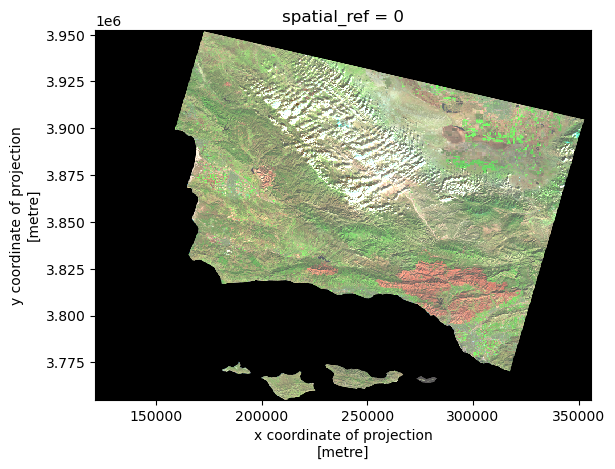

In [13]:
# Select the swir22, near-infrared, and red variables, stack them, and plot as a false color image
sb_rast[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

False color imagery, created using satellite data from instruments like Landsat, is a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars. This approach helps researchers and land managers assess recovery efforts, identify high-risk areas, and plan restoration strategies.

### 5. Map
Finally, I will create a map showing the shortwave infrared/near-infrared/red false color image together with the Thomas Fire perimeter.

<Axes: >

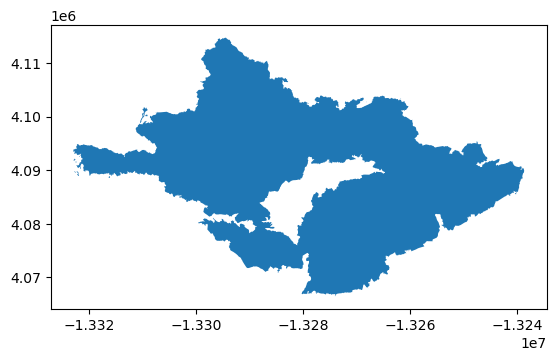

In [14]:
# Read in the Thomas fire perimeter we created
fp2 = os.path.join('data', 'thomas.geojson')
thomas_perim = gpd.read_file(fp2)
thomas_perim.plot()

This initial plot shows us that our perimeter file is looking good. It also shows us the perimeter that we will want to clip our raster file to, in order to create our map analyzing the burn area of the Thomas Fire. 

First, we will have to ensure that our CRS's match for these datasets...

In [15]:
# Examine CRss
print('Santa Barbara Raster CRS: ', sb_rast.rio.crs)
print('Thomas Fire Perimeter CRS: ', thomas_perim.crs)

Santa Barbara Raster CRS:  EPSG:32611
Thomas Fire Perimeter CRS:  EPSG:3857


In [16]:
# Reproject CRS of the Santa Barbara Raster, and use a print statement to ensure it worked
sb_rast = sb_rast.rio.reproject("EPSG:3857")
print('Matched CRS?', sb_rast.rio.crs == thomas_perim.crs)

Matched CRS? True


In [17]:
# Clip the sb_rast map to match the dimensions of the Thomas Fire Perimeter
sb_fire = sb_rast.rio.clip_box(*thomas_perim.total_bounds)

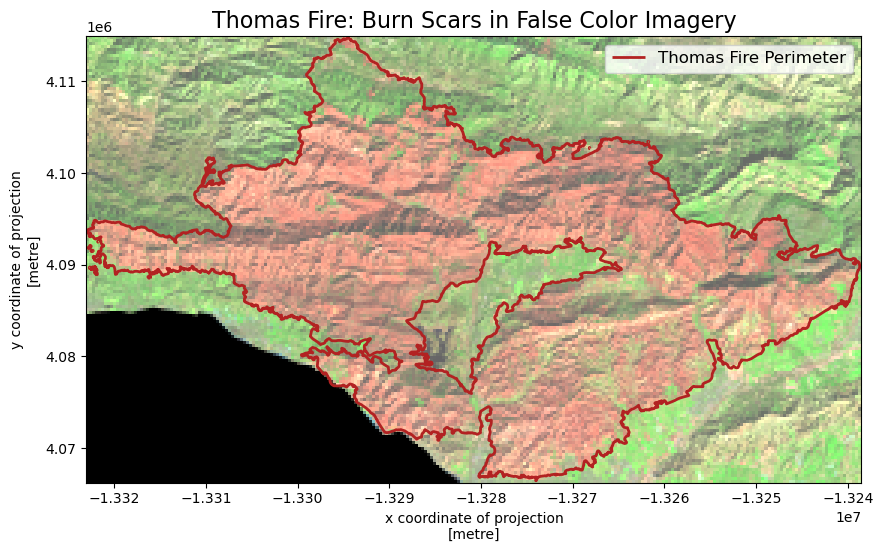

In [18]:
# Map our false color image with the fire boundary overlaid
fig, ax = plt.subplots(figsize=(10, 10))
sb_fire[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax, robust=True)
thomas_perim.boundary.plot(ax=ax, edgecolor="firebrick", linewidth = 2, label="Thomas Fire Perimeter")
ax.set_title("Thomas Fire: Burn Scars in False Color Imagery", fontsize=16)
ax.legend(loc='upper right', fontsize=12)

plt.show()

Our true color image was insufficient to reveal plainly the path of the Thomas Fire. However, by simply utilizing a false color composit, the path of the fire and the effect it had on the landscape are much more clear. 

This final map clearly shows the burn scars from the fire, contained within the perimeter boundary we utilized to help us further identify the exact area effected. 

# Understanding Air Quality in the Aftermath of a Fire

For the final step of my analysis, I will make a plot to aid in visualization for the air quality in Santa Barbara as a result of this fire.

### Complete Workflow

To run this analysis with maximum effiency, I will read in the data, clean it, and plot it all in one code chunk. The result will be a clear and easy to read plot that shows us air quality through time in the region of choice.

Text(0.5, 0, 'Date')

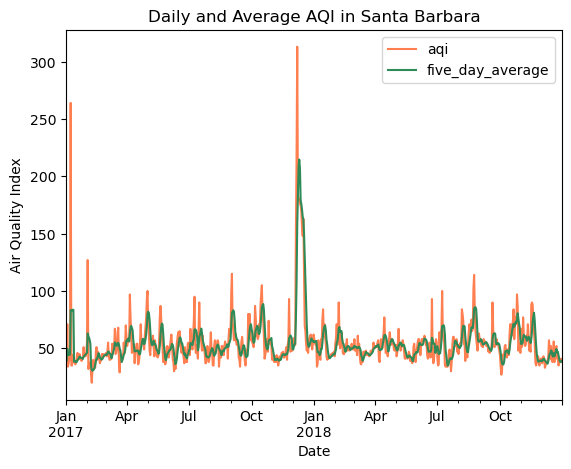

In [19]:
import pandas as pd

# Read and combine AQI data
aqi = pd.concat([
    pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip", compression='zip'),
    pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip", compression='zip')
])

# Clean data and filter for Santa Barbara, and index by date
aqi_sb = (aqi
          .rename(columns=lambda x: x.strip().lower().replace(' ', '_'))  # Simplify column names
          .query("county_name == 'Santa Barbara'")  # Filter for Santa Barbara
          .drop(columns=['state_name', 'county_name', 'state_code', 'county_code'])  # Drop unneeded columns
          .assign(date=lambda x: pd.to_datetime(x['date']))  # Convert date column
          .set_index('date')  # Set date as index
         )

# Calculate and plot the 5-day rolling average AQI next to the daily value
aqi_sb["five_day_average"] = aqi_sb['aqi'].rolling('5D').mean()
catch_aqi_plot = aqi_sb[['aqi', 'five_day_average']].plot(
    kind='line', 
    title="Daily and Average AQI in Santa Barbara",
    color=['coral', 'seagreen']
)
catch_aqi_plot.set_ylabel('Air Quality Index')
catch_aqi_plot.set_xlabel('Date')


Calculating and adding the 5 day rolling average into our plot adds another dimension to the data. Though it lessens more extreme peaks, it shows us that even when averaging out, we can see clear spikes in the Air Quality Index. This helps account for outliers in the data, while still revealing trends. 

## Conclusion

Using Python in Jupiter Notebooks, I have successfully executed a series of analysis analyzing a fire that had clear and lasting effects on the regions of Santa Barbara and Ventura. This analysis also showcases the variety of data types that Python can handle, from spatial data to data visualization. 

### Citations:

AirNow. "Air Quality Index (AQI) Basics." Accessed December 4, 2024. https://www.airnow.gov/aqi/aqi-basics/.

C. Galaz García, EDS 220 - Working with Environmental Datasets, Course Notes. 2024. [Online]. Available: https://meds-eds-220.github.io/MEDS-eds-220-course/book/preface.html

CAL Fire. “California Fire Perimeters (All).” Data.gov. Metadata created March 30, 2024, updated May 14, 2024. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436.

Hamm, Keith. "Closing Schools and Moving Finals Due to Thomas Fire: A Look at Our Education System’s Response to the Wildfire." Santa Barbara Independent, December 13, 2017. https://www.independent.com/2017/12/13/closing-schools-and-moving-finals-due-thomas-fire/.

Microsoft Planetary Computer. Landsat Collection 2 Level-2 Atmospherically Corrected Surface Reflectance Data from Landsat 8 [Dataset]. Simplified for visualization and educational purposes. Accessed November 20, 2024. https://planetarycomputer.microsoft.com.

U.S. Environmental Protection Agency. "Air Data: Air Quality Data Collected at Outdoor Monitors Across the US." Accessed December 4, 2024. https://www.epa.gov/outdoor-air-quality-data. 